In [1]:
from models import util
from models.simpleLSTM import PricePredictionModel, Model
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import random
import math
import os
random.seed(10)

# Hyperparameters

In [2]:
seq_len = 20
batch_size = 256

# Load AAPL Data

In [3]:
ticker = 'AAPL'
baseDataFolder = 'historical_1min'
trainStartDate = '20220101'
trainEndDate = '20220301'
testStartDate = '20220302'
testEndDate = '20220317'
testList, trainList, trainDFList, testDFlist = util.getTrainTestDataList(ticker, 
                          baseDataFolder,
                          trainStartDate=trainStartDate,
                          trainEndDate=trainEndDate,
                          testStartDate=testStartDate,
                          testEndDate=testEndDate,
                          printing=False)

trainDF = pd.concat(trainDFList,ignore_index=True)
testDF = pd.concat(testDFlist,ignore_index=True)
df = pd.concat([trainDF, testDF], ignore_index=True)
train_percent, val_percent = len(trainDF) / (len(trainDF) + len(testDF)) ,  len(testDF) / (len(trainDF) + len(testDF) )
train_index = int(len(df) * train_percent)
val_index = train_index 
test_index = int(train_index + len(testDF)* 0.5)

from CSC413 import DATA
df = pd.read_csv(f'{DATA}/{ticker}.csv')
train_percent, val_percent, test_percent = .8, .2, .1
train_index = int(len(df) * train_percent)
val_index = train_index 
test_index = int(train_index + len(df)*test_percent)

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.544687,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.556002,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.451721,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.439793,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.482608,447610800
...,...,...,...,...,...,...,...
3088,2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
3089,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700
3090,2022-04-12,168.020004,169.869995,166.639999,167.660004,167.660004,79265200
3091,2022-04-13,167.389999,171.039993,166.770004,170.399994,170.399994,70618900


In [5]:
df.iloc[val_index:test_index,:]

,Date,Open,High,Low,Close,Adj Close,Volume
2474,2019-10-31,61.810001,62.292500,59.314999,62.189999,61.018574,139162000
2475,2019-11-01,62.384998,63.982498,62.290001,63.955002,62.750332,151125200
2476,2019-11-04,64.332497,64.462502,63.845001,64.375000,63.162415,103272000
2477,2019-11-05,64.262497,64.547501,64.080002,64.282501,63.071667,79897600
2478,2019-11-06,64.192497,64.372498,63.842499,64.309998,63.098644,75864400
...,...,...,...,...,...,...,...
2778,2021-01-15,128.779999,130.220001,127.000000,127.139999,126.200226,111598500
2779,2021-01-19,127.779999,128.710007,126.940002,127.830002,126.885124,90757300
2780,2021-01-20,128.660004,132.490005,128.550003,132.029999,131.054077,104319500
2781,2021-01-21,133.800003,139.669998,133.589996,136.869995,135.858292,120150900


In [6]:
df.iloc[test_index:,:]

,Date,Open,High,Low,Close,Adj Close,Volume
2783,2021-01-25,143.070007,145.089996,136.539993,142.919998,141.863586,157611700
2784,2021-01-26,143.600006,144.300003,141.369995,143.160004,142.101807,98390600
2785,2021-01-27,143.429993,144.300003,140.410004,142.059998,141.009933,140843800
2786,2021-01-28,139.520004,141.990005,136.699997,137.089996,136.076675,142621100
2787,2021-01-29,135.830002,136.740005,130.210007,131.960007,130.984604,177523800
...,...,...,...,...,...,...,...
3088,2022-04-08,171.779999,171.779999,169.199997,170.089996,170.089996,76515900
3089,2022-04-11,168.710007,169.029999,165.500000,165.750000,165.750000,72246700
3090,2022-04-12,168.020004,169.869995,166.639999,167.660004,167.660004,79265200
3091,2022-04-13,167.389999,171.039993,166.770004,170.399994,170.399994,70618900


# Plot AAPL close prices

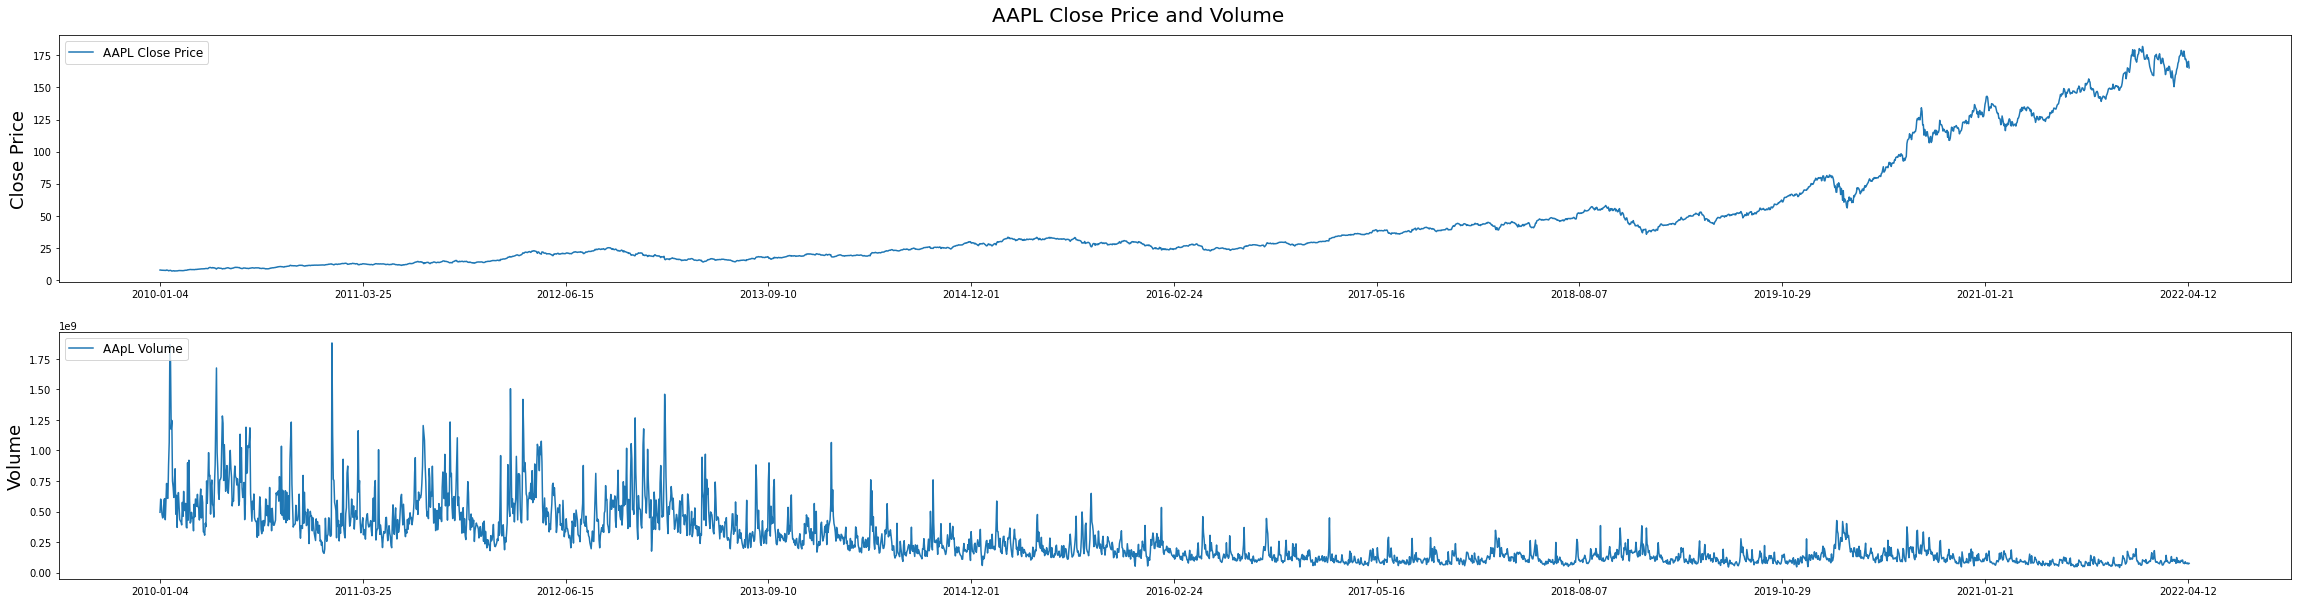

In [7]:
fig = plt.figure(figsize=(40, 10))
st = fig.suptitle("AAPL Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax1.set_xticklabels(df['Date'].loc[:: len(df)  // 10]) # ax1.set_xticklabels(df['DateTime'].loc[:: len(df)  // 10])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='AApL Volume')
ax2.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax2.set_xticklabels(df['Date'].loc[:: len(df)  // 10]) # ax2.set_xticklabels(df['DateTime'].loc[:: len(df)  // 10])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

# Normalize data

In [8]:
scaler = MinMaxScaler()
normalizedDF = pd.DataFrame(data=df.loc[:,['Open','Close','High','Low', 'Volume']], columns=['Open','Close','High','Low', 'Volume'])
normalizedDF[['Open','Close','High','Low', 'Volume']] = scaler.fit_transform(df.loc[:,['Open','Close','High','Low', 'Volume']])
# normalizedDF = pd.DataFrame(data=df.loc[:,['Open','Close','High','Low']], columns=['Open','Close','High','Low'])
# normalizedDF[['Open','Close','High','Low']] = scaler.fit_transform(df.loc[:,['Open','Close','High','Low']])
normalizedDF

,Open,Close,High,Low,Volume
0,0.004279,0.004478,0.003755,0.004586,0.246049
1,0.004517,0.004553,0.003977,0.004767,0.304840
2,0.004472,0.003858,0.003904,0.004249,0.277805
3,0.003938,0.003778,0.003248,0.003896,0.237028
4,0.003643,0.004064,0.003248,0.003898,0.220984
...,...,...,...,...,...
3088,0.938268,0.931944,0.936569,0.942434,0.019302
3089,0.920801,0.907166,0.920939,0.920963,0.016982
3090,0.916875,0.918071,0.925713,0.927579,0.020796
3091,0.913291,0.933714,0.932363,0.928333,0.016097


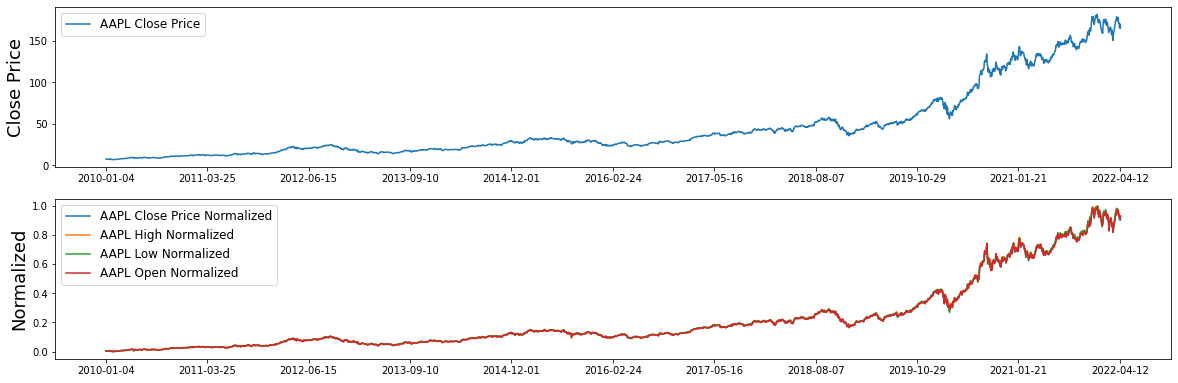

In [72]:
fig2 = plt.figure(figsize=(20, 10))
ax1 = fig2.add_subplot(311)
ax1.plot(df['Close'], label='AAPL Close Price')
ax1.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax1.set_xticklabels(df['Date'].loc[:: len(df)  // 10])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig2.add_subplot(312)
ax2.plot(normalizedDF['Close'], label='AAPL Close Price Normalized')
ax2.plot(normalizedDF['High'], label='AAPL High Normalized')
ax2.plot(normalizedDF['Low'], label='AAPL Low Normalized')
ax2.plot(normalizedDF['Open'], label='AAPL Open Normalized')
ax2.set_xticks(range(0, df.shape[0],  len(df)  // 10))
ax2.set_xticklabels(df['Date'].loc[:: len(df)  // 10])
ax2.set_ylabel('Normalized', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)


# Create chunks of training, validation and test data

In [10]:
train_data = normalizedDF.iloc[:train_index,:].to_numpy()
val_data = normalizedDF.iloc[val_index:test_index,:].to_numpy()
test_data = normalizedDF.iloc[test_index:,:].to_numpy()

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 1][i]) #Value of 2nd column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 1][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)

Training set shape (2454, 20, 5) (2454,)
Validation set shape (289, 20, 5) (289,)


In [19]:
def learn(model,args):
    
    model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  
    print(f'Model total parameters: {model_total_params}')
    # optimizer = optim.Adam(model.parameters(), lr = args.learning_rate, betas=[0.9, 0.999], weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr = args.learning_rate)
    criterion = nn.MSELoss()
    
    import random
    random.seed(10)
    
    optStep = 0
    running_loss = 0
    epoch = 1
    validation_losses = []
    train_losses = []
    Y_val = torch.FloatTensor(y_val).to(device)
    
    
    # save folders
    base_log_folder = './log'
    save_folder = f'{base_log_folder}/{args.training_name}-e{args.total_epoch}-lr{args.learning_rate}-{args.ff_dims}-nL{args.nLayers}'
    if not os.path.isdir(base_log_folder):
        os.mkdir(base_log_folder)
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    else:
        count = 2
        save_folder = f'{save_folder}_{count}'
        while os.path.isdir(save_folder):
            count+=1
            save_folder = f'{save_folder}_{count}'
        os.mkdir(save_folder)
    
    for epoch in range(args.total_epoch):
        cursor = 0
        epoch_loss = []
        if args.miniBatch:
            for i in range(math.ceil(X_train.shape[0]/args.batch_size)):
                cursor = i * args.batch_size
                end_cursor = (i + 1) * args.batch_size 
                # samples = random.sample(range(0, X_train.shape[0]), batch_size)

                # x = X_train[:i, :, :]
                # y = y_train[samples]

                x = X_train[cursor: end_cursor, :, :] 
                y = y_train[cursor: end_cursor]

                y = torch.FloatTensor(y).to(device)
                predictions = model(x)

                loss = criterion(predictions, y)

                loss.backward()
                optimizer.step()

                epoch_loss.append(loss.item())
            running_loss = np.average(epoch_loss)
            epoch += 1
        else:
            y = torch.FloatTensor(y_train).to(device)
            predictions = model(X_train)

            loss = criterion(predictions, y)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            running_loss = np.average(epoch_loss)
            epoch += 1
        
        if epoch % args.validation_window == 0:
            # validation
            predictions = model(X_val)
            loss = criterion(predictions, Y_val).squeeze().item()
            if epoch % args.save_window == 0:
                torch.save(model, f'{save_folder}/policy_{epoch}.para')
                
            print(str(epoch) + ' epoch. Train loss is ' + str(running_loss))
            util.printOkBlue(str(epoch) + ' epoch. Validation loss is ' + str(loss))
            train_losses.append(running_loss)
            validation_losses.append(loss)
    
    print(f'training done')
    return train_losses, validation_losses, save_folder


# LSTM Base Model

Model total parameters: 38390
100 epoch. Train loss is 0.003004074562340975
100 epoch. Validation loss is 0.10033785551786423
200 epoch. Train loss is 0.0028379682917147875
200 epoch. Validation loss is 0.054411277174949646
300 epoch. Train loss is 0.006250458769500256
300 epoch. Validation loss is 0.010018207132816315
400 epoch. Train loss is 0.0037441749591380358
400 epoch. Validation loss is 0.07342052459716797
500 epoch. Train loss is 0.001842467812821269
500 epoch. Validation loss is 0.0709603875875473
600 epoch. Train loss is 0.003271897090598941
600 epoch. Validation loss is 0.036839257925748825
700 epoch. Train loss is 0.001072499668225646
700 epoch. Validation loss is 0.03862830996513367
800 epoch. Train loss is 0.002421148819848895
800 epoch. Validation loss is 0.04376951605081558
900 epoch. Train loss is 0.00026847884873859584
900 epoch. Validation loss is 0.01054710615426302
1000 epoch. Train loss is 0.002865218324586749
1000 epoch. Validation loss is 0.0012522563338279724


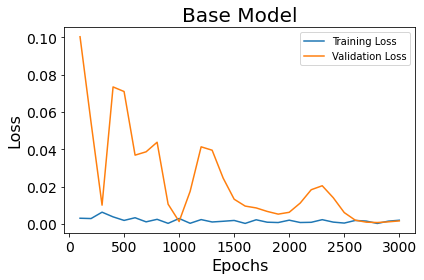

In [26]:
args = util.AttrDict()
args_dict = {
    "cuda": True,
    "learning_rate": 0.0001, ## 
    "batch_size": batch_size,
    "device": 'cuda:1',
    "seq_len": seq_len,
    "ff_dims": 68, ##
    "dropout": 0.2, ##
    "weight_decay": 0.001,
    "total_epoch": 3000,
    "validation_window": 100,
    "nLayers": 1, ##
    "miniBatch": False,
    "save_window": 100,
    "training_name": 'baseModelMostRecent',
}
args.update(args_dict)
device = torch.device(args.device)
# model = Model(train_data.shape[1],1, args=args).to(device)
model = PricePredictionModel(train_data.shape[1],1, args=args).to(device)



t_loss, v_loss, save_dir = learn(model, args)

def plot_loss(t_loss, v_loss, title, save_dir):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    plt.figure()
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), t_loss)
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), v_loss)
    plt.title(title, fontsize=20)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.tight_layout()
    plt.savefig(save_dir + "/loss_plot.png")
plot_loss(t_loss, v_loss, 'Base Model', save_dir)   

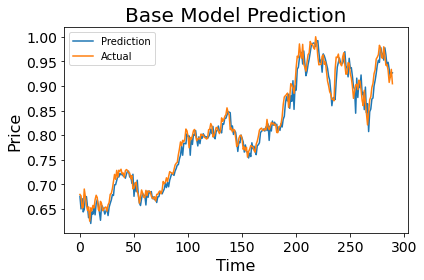

In [53]:
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/baseModel-lr0.0001-64-1-2/policy_1130.para') # best model for less recent data
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/baseModelMostRecent-lr0.0001-72-1/policy_1600.para') 
model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/baseModelMostRecent-lr0.0001-68-1/policy_2200.para') # best model for more recent data, val loss: 0.0003635
predictions = model(X_test).squeeze().cpu().detach().numpy()
plt.figure()
plt.plot(range(len(predictions)), predictions, label='Prediction')
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.title('Base Model Prediction', fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Price", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()

# Neural ODE

#### 3000 epoch, 84 hidden dim

Model total parameters: 73293
10 epoch. Train loss is 0.027000000700354576
10 epoch. Validation loss is 0.2850123643875122
20 epoch. Train loss is 0.005667535588145256
20 epoch. Validation loss is 0.15350952744483948
30 epoch. Train loss is 0.017065120860934258
30 epoch. Validation loss is 0.06060703471302986
40 epoch. Train loss is 0.05268346145749092
40 epoch. Validation loss is 0.01930852048099041
50 epoch. Train loss is 0.061400048434734344
50 epoch. Validation loss is 0.01438550092279911
60 epoch. Train loss is 0.02699284628033638
60 epoch. Validation loss is 0.03557853028178215
70 epoch. Train loss is 0.0038863159716129303
70 epoch. Validation loss is 0.10305260121822357
80 epoch. Train loss is 0.015528480522334576
80 epoch. Validation loss is 0.2093603014945984
90 epoch. Train loss is 0.05011894553899765
90 epoch. Validation loss is 0.31936806440353394
100 epoch. Train loss is 0.07946977019309998
100 epoch. Validation loss is 0.3812175393104553
110 epoch. Train loss is 0.0774328

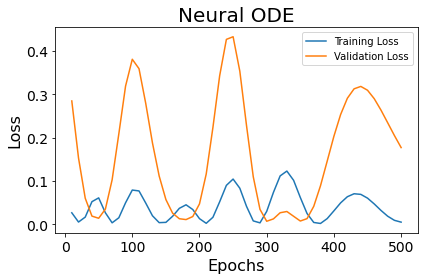

In [20]:
from models.ODE import CDEFunc, NeuralCDE
import torchcde

args = util.AttrDict()
args_dict = {
    "cuda": True, 
    "learning_rate": 0.0001, ##
    "batch_size": batch_size,
    "device": 'cuda:1',
    "seq_len": seq_len,
    "ff_dims": 78, # hidden ##
    "dropout": 0.2,
    "weight_decay": 0.001,
    "total_epoch": 500, ##
    "validation_window": 10,
    "nLayers": 1,
    "miniBatch": False,
    "save_window": 10,
    "training_name": 'nODE128',
}
args.update(args_dict)
device = torch.device(args.device)
model = NeuralCDE(train_data.shape[1],args.ff_dims, 1,args=args).to(device)
tode_loss, vode_loss, save_dir = learn(model, args)


def plot_loss(t_loss, v_loss, title, save_dir):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    plt.figure()
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), t_loss)
    plt.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), v_loss)
    plt.title(title, fontsize=20)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.tight_layout()
    plt.savefig(save_dir + "/loss_plot.png")

plot_loss(tode_loss, vode_loss, 'Neural ODE', save_dir)

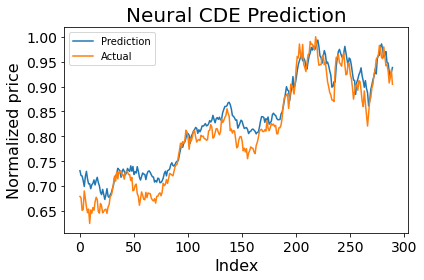

In [48]:
model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE128_L1-e500-lr0.0001-78-nL1/policy_180.para') # best model so far 
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE128-e500-lr0.0001-78-nL1/policy_300.para') # val loss: 0.007438
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE128_L1-e500-lr0.0001-78-nL1_2_3_4/policy_360.para') # val loss: 0.081
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE128_L1_2layers-e500-lr0.0001-78-nL2/policy_380.para') # val loss: 0.099
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE-e3000-lr0.0001-32-nL1/policy_1300.para')  # loss 0.0023654
# model = torch.load('/home/guest/CSC413/CSC413GroupProject/log/nODE128_MSE-e500-lr0.0001-78-nL1/policy_220.para')  # val loss: 0.00270449137

cde_predictions = model(X_test).squeeze().cpu().detach().numpy()
plt.figure()
plt.plot(range(len(cde_predictions)), cde_predictions, label='Prediction')
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.title('Neural CDE Prediction', fontsize=20)
plt.xlabel("Index", fontsize=16)
plt.ylabel("Normalized price", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()

# Results

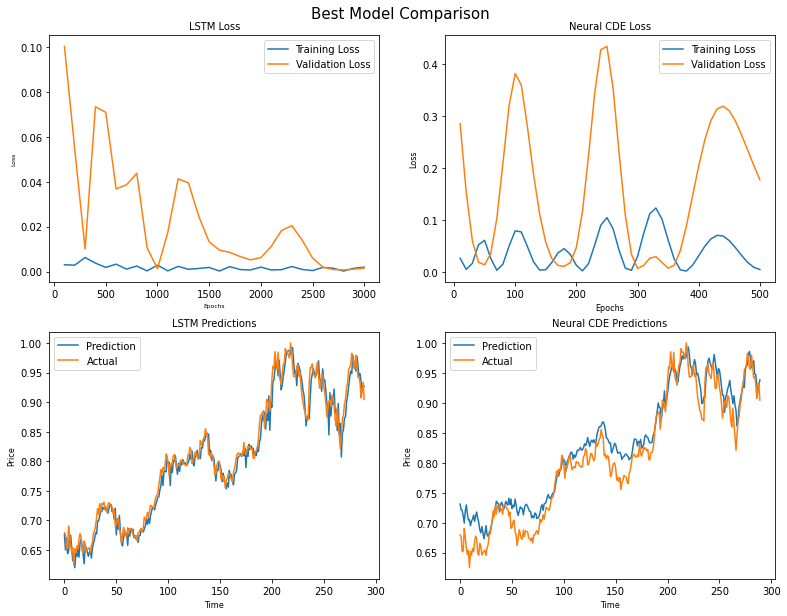

In [69]:
fig = plt.figure(figsize=(13, 10))
st = fig.suptitle("Best Model Comparison", fontsize=15)
st.set_y(0.92)

ax1 = fig.add_subplot(221)

ax1.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), t_loss)
ax1.plot(range(args.validation_window, args.total_epoch + 1, args.validation_window), v_loss)
ax1.set_title('LSTM Loss', fontsize=10)
ax1.set_xlabel("Epochs", fontsize=6)
ax1.set_ylabel("Loss", fontsize=6)
ax1.legend(["Training Loss", "Validation Loss"])

ax2 = fig.add_subplot(222)

ax2.plot(range(10, 500 + 1, 10), tode_loss)
ax2.plot(range(10, 500 + 1, 10), vode_loss)
ax2.set_title('Neural CDE Loss', fontsize=10)
ax2.set_xlabel("Epochs", fontsize=8)
ax2.set_ylabel("Loss", fontsize=8)
ax2.legend(["Training Loss", "Validation Loss"])

ax3 = fig.add_subplot(223)

ax3.plot(range(len(predictions)), predictions, label='Prediction')
ax3.plot(range(len(y_test)), y_test, label='Actual')
ax3.set_title('LSTM Predictions', fontsize=10)
ax3.set_xlabel("Time", fontsize=8)
ax3.set_ylabel("Price", fontsize=8)
ax3.legend(["Prediction", "Actual"])

ax4 = fig.add_subplot(224)

ax4.plot(range(len(cde_predictions)), cde_predictions, label='Prediction')
ax4.plot(range(len(y_test)), y_test, label='Actual')
ax4.set_title('Neural CDE Predictions', fontsize=10)
ax4.set_xlabel("Time", fontsize=8)
ax4.set_ylabel("Price", fontsize=8)
ax4.legend(["Prediction", "Actual"])


fig.savefig(f"./Summary13.png")